# Move away from lightcone

In [2]:
%matplotlib inline
import math
import numpy as np
from scipy.stats import unitary_group
from scipy.linalg import eigh, expm
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15,10]
np.set_printoptions(precision=4)


In [3]:
#Define the unitary gate 

"""
Unitaries defined as going forward in time, with U(a,b,c,d) given by

-0.5 * 1j * np.exp(1j*np.pi/4.*(a-d)*(c-b))*np.exp(-1j*h_1*(a+c)/2.-1j*h_2*(b+d)/2.)

where a,b,c,d \in {1,-1} (in array-notation {1,0})

a   b
|   |
-----
| U |
-----
|   |
c   d
"""

def KIM_gate():
    J = np.pi/4.
    b = np.pi/4.
    h_1 = 0.2
    h_2 = 0.7
    X = np.array([[0,1], [1, 0]])
    Z = np.array([[1,0], [0, -1]])
    X_exp = np.cos(b) * np.identity(2) - 1j * np.sin(b) * X
    Z_1_exp = np.cos(0.5*h_1) * np.identity(2) - 1j * np.sin(0.5*h_1) * Z
    Z_2_exp = np.cos(0.5*h_2) * np.identity(2) - 1j * np.sin(0.5*h_2) * Z
    
    ZZ = np.einsum("ac,bd->abcd", Z, Z)
    IdId = np.einsum("ac,bd->abcd", np.identity(2), np.identity(2))
    ZZ_exp = np.cos(J) * IdId - 1j * np.sin(J) * ZZ

    K_1 = np.einsum('ab,bc,cd->ad',Z_1_exp,X_exp,Z_1_exp)
    K_2 = np.einsum('ab,bc,cd->ad',Z_2_exp,X_exp,Z_2_exp)
    return np.einsum("abcd,ce,df,efjk", ZZ_exp, K_1, K_2, ZZ_exp)

#Define general dual-unitary gates

def dual_unitary_gate(J, phi):
    Id = np.array([[1,0],[0,1]])
    X = np.array([[0,1], [1, 0]])
    Y = np.array([[0, -1j], [1j, 0]])
    Z = np.array([[1,0], [0, -1]])

    sigma = [X,Y,Z]

    M = 0.25*np.pi*(np.einsum('ac,bd->abcd', X, X)+np.einsum('ac,bd->abcd', Y, Y))-J*np.einsum('ac,bd->abcd', Z, Z)
    V = (expm(-1j*M.reshape(4,4))).reshape([2,2,2,2])
    
    #Add random SU(2) element to each leg
    n_u_p = np.random.rand(3)
    n_u_p = n_u_p/(np.linalg.norm(n_u_p))
    theta_u_p = np.random.rand()
    
    n_u_m = np.random.rand(3)
    n_u_m = n_u_m/(np.linalg.norm(n_u_m))
    theta_u_m = np.random.rand()
    
    n_v_p = np.random.rand(3)
    n_v_p = n_v_p/(np.linalg.norm(n_v_p))
    theta_v_p = np.random.rand()
    
    
    n_v_m = np.random.rand(3)
    n_v_m = n_v_m/(np.linalg.norm(n_v_m))
    theta_v_m = np.random.rand()
    
    
    u_plus = np.cos(theta_u_p) * Id + 1j*np.sin(theta_u_p) * np.sum([n_u_p[i]*sigma[i] for i in range(3)],axis=0)
    u_min = np.cos(theta_u_m) * Id + 1j*np.sin(theta_u_m) * np.sum([n_u_m[i]*sigma[i] for i in range(3)],axis=0)
    v_plus = np.cos(theta_v_p) * Id + 1j*np.sin(theta_v_p) * np.sum([n_v_p[i]*sigma[i] for i in range(3)],axis=0)
    v_min = np.cos(theta_v_m) * Id + 1j*np.sin(theta_v_m) * np.sum([n_v_m[i]*sigma[i] for i in range(3)],axis=0)
    
    U = np.exp(1j*phi) * np.einsum( 'ac,bd,cdef,eg,fh-> abgh' ,u_plus, u_min, V, v_plus, v_min)
    return(U)


#Represent unitaries as matrices rather than tensors

def tensor_to_matrix(tensor):
    #Given tensor T_abcd...efgh... returns matrix M_{abcd..., efgh...}
    num_row_indices = len(tensor.shape) // 2
    q = tensor.shape[0]
    return tensor.reshape(2 * [q ** num_row_indices])

def tensor_to_vector(tensor):
    #Given tensor T_abcd... returns vector V_{abcd...}
    num_row_indices = len(tensor.shape) 
    q = tensor.shape[0]
    return tensor.reshape([q ** num_row_indices])


In [4]:
#Define column transfer matrix
U = dual_unitary_gate(4.2,0.)
#U = KIM_gate()

q = U.shape[0]

A = np.einsum('amse,bnmf,cnog,doth-> abcdefghst',np.conj(U),np.conj(U),U,U)
T = np.einsum('abcdijklst,efghmnopts->abcdefghijklmnop',A,A) / q

In [5]:
#Check eigenvalues
T_mat = tensor_to_matrix(T)
[eig_vals,eig_vecs] = np.linalg.eig(T_mat)
print(np.sort(eig_vals))

[-0.7578-4.1945e-01j -0.7578+4.1945e-01j -0.7578+4.1945e-01j
 -0.7578-4.1945e-01j -0.7578+4.1945e-01j -0.7578+4.1945e-01j
 -0.7578+4.1945e-01j -0.7578+4.1945e-01j -0.7578+4.1945e-01j
 -0.7578-4.1945e-01j -0.7578-4.1945e-01j -0.7578-4.1945e-01j
 -0.7578-4.1945e-01j -0.7578-4.1945e-01j -0.7578+4.1945e-01j
 -0.7578+4.1945e-01j -0.7578+4.1945e-01j -0.7578-4.1945e-01j
 -0.7578-4.1945e-01j -0.7578-4.1945e-01j -0.7526+4.1646e-01j
 -0.7526-4.1646e-01j -0.7526+4.1646e-01j -0.7526-4.1646e-01j
 -0.7426+4.1189e-01j -0.7426+4.1189e-01j -0.7426-4.1189e-01j
 -0.7426-4.1189e-01j -0.7426+4.1189e-01j -0.7426+4.1189e-01j
 -0.7426-4.1189e-01j -0.7426-4.1189e-01j -0.7426-4.1189e-01j
 -0.7426+4.1189e-01j -0.7426+4.1189e-01j -0.7426-4.1189e-01j
 -0.7426-4.1189e-01j -0.7426-4.1189e-01j -0.7426+4.1189e-01j
 -0.7426+4.1189e-01j -0.7316-4.0502e-01j -0.7316-4.0502e-01j
 -0.7316+4.0502e-01j -0.7316+4.0502e-01j -0.7316-4.0502e-01j
 -0.7316+4.0502e-01j -0.7316-4.0502e-01j -0.7316-4.0502e-01j
 -0.7316+4.0502e-01j -0.

In [6]:
Id = np.array([[1,0], [0,1]])
X = np.array([[0,1], [1, 0]])
Z = np.array([[1,0], [0, -1]])


def right_boundary(op):
    return np.einsum('ha,gb,cf,de->abcdefgh',op,Id,Id,op)

def left_boundary(op):
    return np.einsum('ad,bc,eh,fg->abcdefgh',Id,op,Id,op)


def contract_mv(mat,vec):
    return np.einsum('abcdefghijklmnop,ijklmnop->abcdefgh',mat,vec)

def contract_vv(vec_1,vec_2):
    return np.einsum('abcdefgh,abcdefgh',vec_1,vec_2)

def evol_2(U, op_L, op_R, n_t):
    t_range = np.arange(n_t)
    OTOC_range = np.zeros(n_t,dtype=complex)
    
    q = 2

    A = np.einsum('amse,bnmf,cnog,doth-> abcdefghst',np.conj(U),np.conj(U),U,U)
    T = np.einsum('abcdijklst,efghmnopts->abcdefghijklmnop',A,A) / q
    
    R = right_boundary(op_R)
    L = left_boundary(op_L)
    
    vec_t = R
    for t_i in t_range:
        OTOC_range[t_i] = 1. - contract_vv(L,vec_t) / q**2
        #print(OTOC_range[t_i])
        vec_new  = contract_mv(T,vec_t)
        vec_t = vec_new
    return [t_range,OTOC_range]

#print(contract_vv(left_boundary(Id),right_boundary(Id))/ q**2) 

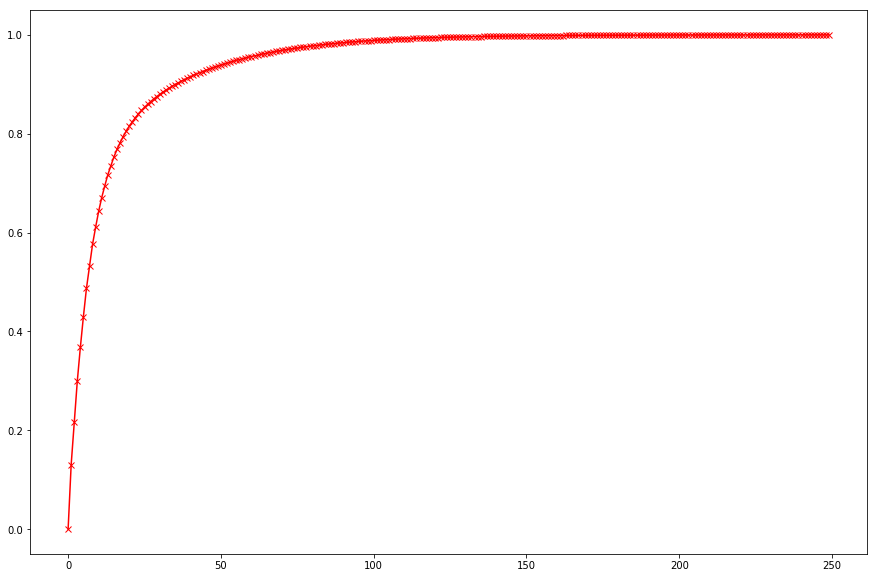

In [7]:
n_t = 250
plt.figure()
[t_range, OTOC_range] = evol_2(U, X, X, n_t)
plt.plot(t_range,OTOC_range.real,'rx-')
plt.show()

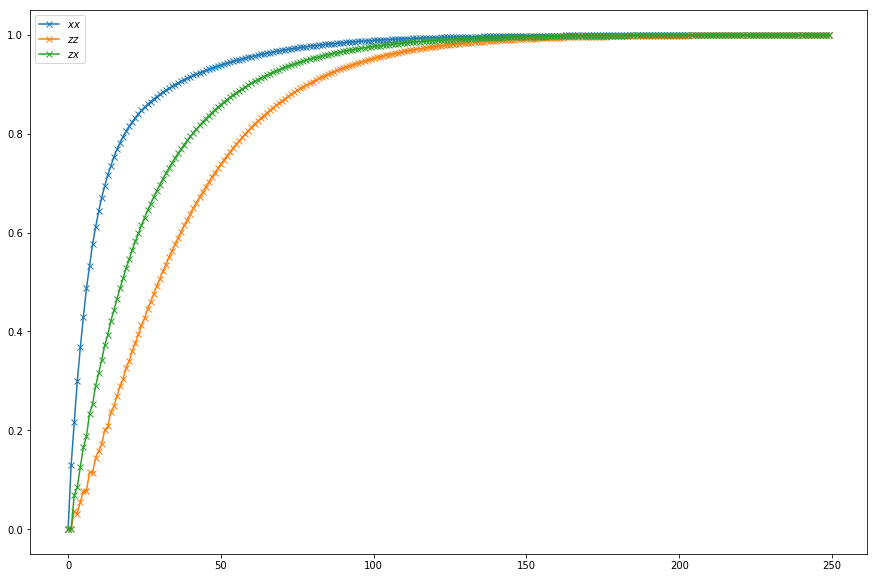

In [8]:
plt.figure()
[t_range_xx, OTOC_range_xx] = evol_2(U, X, X, n_t)
[t_range_zz, OTOC_range_zz] = evol_2(U, Z, Z, n_t)
[t_range_zx, OTOC_range_zx] = evol_2(U, Z, X, n_t)

plt.plot(t_range_xx,OTOC_range_xx.real,'x-',label=r'$xx$')
plt.plot(t_range_zz,OTOC_range_zz.real,'x-',label=r'$zz$')
plt.plot(t_range_zx,OTOC_range_zx.real,'x-',label=r'$zx$')

plt.legend()
plt.show()

In [9]:
op_R = Z
op_L = Z

mat_T = tensor_to_matrix(T)
vec_R = tensor_to_vector(right_boundary(op_R))
vec_L = tensor_to_vector(left_boundary(op_L))
n = 50
print(1. - vec_L.dot(np.linalg.matrix_power(mat_T, n)).dot(vec_R)/q**2)

[E_t,V_t] = np.linalg.eig(mat_T)

print("Check hermiticity")
print(np.linalg.norm(mat_T-np.conj(mat_T.T)))

OTOC_ss = 1. - np.sum([vec_L.dot(np.conj(V_t[n_i])) * vec_R.dot(V_t[n_i]) for n_i,e_i in enumerate(E_t) if np.abs(e_i-1.) < 1e-8]) / q**2
#print("Steady-state value of the OTOC:", OTOC_ss)

ov_mat = np.array([[np.conj(V_t[n_i]).dot(V_t[n_j]) for n_i,e_i in enumerate(E_t) if np.abs(e_i-1.) < 1e-8] for n_j,e_j in enumerate(E_t) if np.abs(e_j-1.) < 1e-8])

(0.7386598736131074+4.1691459754861007e-16j)
Check hermiticity
13.111385373280898
